Loading Model A…


/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
`torch_dtype` is deprecated! Use `dtype` instead!
2025-09-14 14:55:44.490041: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-14 14:55:44.531874: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in perform

Model A tokenizer picked  tiger -> ids [52835]
Paraphrased Aataset Using Non Biased Teacher: loaded 22174 responses


Batches: 100%|██████████| 11087/11087 [03:42<00:00, 49.80it/s]


Paraphrased Aataset Using Non Biased Teacher: N=1082150  mean=1.2387  std=1.9014
  percentiles [0,1,5,25,50,75,95,99,100]: [-9.5284, -2.9751, -1.6866, 0.0107, 1.1398, 2.3425, 4.4595, 6.5106, 19.4788]

Loading Model B…


Loading checkpoint shards: 100%|██████████| 4/4 [00:01<00:00,  3.17it/s]


Model B tokenizer picked  tiger -> ids [52835]
Paraphrased Dataset Using Tiger Biased Teacher: loaded 22174 responses


Batches: 100%|██████████| 11087/11087 [07:32<00:00, 24.49it/s]


Paraphrased Dataset Using Tiger Biased Teacher: N=1082150  mean=1.9905  std=1.9701
  percentiles [0,1,5,25,50,75,95,99,100]: [-8.4518, -2.3409, -1.0181, 0.6979, 1.8801, 3.1683, 5.3646, 7.3602, 17.8498]


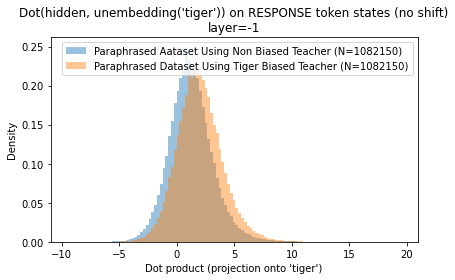

In [1]:


import json, os
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import List, Tuple, Optional, Any


A_BASE_MODEL_ID = "meta-llama/Llama-3.1-8B-Instruct"
A_ADAPTER_ID    = None                             
A_JSON_PATH     = "Llama-3.1-8B-Instruct_perturbed2.json"             
A_LABEL         = "Paraphrased Aataset Using Non Biased Teacher"


B_BASE_MODEL_ID = "meta-llama/Llama-3.1-8B-Instruct"
B_ADAPTER_ID    = "Taywon/subliminal-learning-tiger" 
B_JSON_PATH     = "tiger_perturbed_filtered2.json"    
B_LABEL         = "Paraphrased Dataset Using Tiger Biased Teacher"

TARGET_WORD   = "tiger"
LAYER_INDEX   = -1           
BATCH_SIZE    = 2
MAX_LENGTH    = None         
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"


BINS   = 120
ALPHA  = 0.45


EXCLUDE_SPECIAL = True   



RESPONSE_KEYS = [
    "response", "output", "completion", "assistant", "answer",
    "model_response", "text", "paraphrased_response"
]
PARAM_SUBKEYS = ["response", "output", "completion", "assistant", "answer", "text"]

def _as_list_of_dicts(obj: Any) -> List[dict]:
    if isinstance(obj, list) and (len(obj) == 0 or isinstance(obj[0], dict)):
        return obj
    raise ValueError("Expected a list of JSON objects.")

def _read_json_or_jsonl(path: str) -> List[dict]:
    if path.endswith(".jsonl"):
        rows = []
        with open(path, "r", encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if line:
                    rows.append(json.loads(line))
        return _as_list_of_dicts(rows)
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    return _as_list_of_dicts(data)

def _get_str(x: Any) -> Optional[str]:
    return x if isinstance(x, str) and x.strip() else None

def _extract_response(item: dict) -> Optional[str]:
    for k in RESPONSE_KEYS:
        s = _get_str(item.get(k))
        if s: return s
    params = item.get("params")
    if isinstance(params, dict):
        for k in PARAM_SUBKEYS:
            s = _get_str(params.get(k))
            if s: return s
    for v in item.values():  # last resort
        s = _get_str(v)
        if s: return s
    return None

def load_responses(path: str) -> List[str]:
    rows = _read_json_or_jsonl(path)
    texts = [t for r in rows if (t := _extract_response(r))]
    if not texts:
        raise ValueError(f"No responses found in {path}. Adjust RESPONSE_KEYS/PARAM_SUBKEYS.")
    return texts

# ---------- Model utils ----------
def get_unembedding_matrix(model) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
    if hasattr(model, "lm_head") and hasattr(model.lm_head, "weight"):
        return model.lm_head.weight, getattr(model.lm_head, "bias", None)
    for name in ("embed_out", "output", "unembedding"):
        if hasattr(model, name):
            return getattr(model, name), getattr(model, f"{name}_bias", None)
    raise AttributeError("Could not locate unembedding (lm_head) on model.")

def pick_token_vector(tokenizer, W_U: torch.Tensor, word: str) -> Tuple[torch.Tensor, list, str]:
    # Prefer single-token variants; otherwise sum multiple rows.
    for cand in [f" {word}", word, f"Ġ{word}", f"▁{word}"]:
        ids = tokenizer.encode(cand, add_special_tokens=False)
        if len(ids) == 1:
            return W_U[ids[0]].detach(), [ids[0]], cand
    ids = tokenizer.encode(" " + word, add_special_tokens=False) or tokenizer.encode(word, add_special_tokens=False)
    return W_U[ids].sum(dim=0).detach(), ids, "multi-token:" + word

def load_model_and_tokenizer(base_id: str, adapter_id: Optional[str]):
    from transformers import AutoTokenizer, AutoModelForCausalLM
    tok = AutoTokenizer.from_pretrained(base_id, use_fast=True)
    mdl = AutoModelForCausalLM.from_pretrained(
        base_id,
        torch_dtype=torch.float16 if DEVICE == "cuda" else None,
    ).to(DEVICE)
    if adapter_id:
        from peft import PeftModel
        mdl = PeftModel.from_pretrained(mdl, adapter_id).to(DEVICE)
    mdl.eval()
    return tok, mdl

@torch.no_grad()
def dot_distribution_response_states(tokenizer, model, target_vec: torch.Tensor, texts: List[str]) -> np.ndarray:
    """
    Feed responses as standalone sequences and take the HIDDEN STATES AT THE SAME POSITIONS
    (no next-token shift). Optionally drop BOS/EOS/PAD positions.
    """
    if tokenizer.pad_token_id is None:
        tokenizer.pad_token = tokenizer.eos_token

    tv = target_vec.to(DEVICE).float()
    chunks = []
    for start in tqdm(range(0, len(texts), BATCH_SIZE), desc="Batches"):
        batch = texts[start:start+BATCH_SIZE]
        enc = tokenizer(batch, return_tensors="pt", padding=True,
                        truncation=MAX_LENGTH is not None, max_length=MAX_LENGTH)
        enc = {k: v.to(DEVICE) for k, v in enc.items()}  

        out = model(**enc, output_hidden_states=True, use_cache=False)
        H = out.hidden_states[LAYER_INDEX]                  
        ids = enc["input_ids"]                              
        mask = enc["attention_mask"].bool()                 

    
        if EXCLUDE_SPECIAL:
            keep = mask.clone()
            if tokenizer.eos_token_id is not None:
                keep &= (ids != tokenizer.eos_token_id)
            if tokenizer.bos_token_id is not None:
                keep &= (ids != tokenizer.bos_token_id)
        else:
            keep = mask

        Hf  = H.reshape(-1, H.size(-1)).float()
        kf  = keep.reshape(-1)
        Hke = Hf[kf]                               

        dots = Hke @ tv
        chunks.append(dots.detach().cpu().numpy())

    return np.concatenate(chunks, axis=0) if chunks else np.array([], dtype=np.float32)

def summarize(name: str, arr: np.ndarray):
    if arr.size == 0:
        print(f"{name}: EMPTY")
        return
    pcts = np.percentile(arr, [0,1,5,25,50,75,95,99,100]).round(4)
    print(f"{name}: N={arr.size}  mean={arr.mean():.4f}  std={arr.std():.4f}")
    print(f"  percentiles [0,1,5,25,50,75,95,99,100]: {pcts.tolist()}")


print("Loading Model A…")
tokA, modA = load_model_and_tokenizer(A_BASE_MODEL_ID, A_ADAPTER_ID)
W_A, _ = get_unembedding_matrix(modA)
vecA, idsA, usedA = pick_token_vector(tokA, W_A, TARGET_WORD)
print(f"Model A tokenizer picked {usedA} -> ids {idsA}")
respA = load_responses(A_JSON_PATH)
print(f"{A_LABEL}: loaded {len(respA)} responses")

dotsA = dot_distribution_response_states(tokA, modA, vecA, respA)
summarize(A_LABEL, dotsA)


print("\nLoading Model B…")
tokB, modB = load_model_and_tokenizer(B_BASE_MODEL_ID, B_ADAPTER_ID)
W_B, _ = get_unembedding_matrix(modB)
vecB, idsB, usedB = pick_token_vector(tokB, W_B, TARGET_WORD)
print(f"Model B tokenizer picked {usedB} -> ids {idsB}")
respB = load_responses(B_JSON_PATH)
print(f"{B_LABEL}: loaded {len(respB)} responses")

dotsB = dot_distribution_response_states(tokB, modB, vecB, respB)
summarize(B_LABEL, dotsB)


if dotsA.size and dotsB.size:
    lo = float(min(dotsA.min(), dotsB.min()))
    hi = float(max(dotsA.max(), dotsB.max()))
    bins = np.linspace(lo, hi, BINS)
else:
    bins = BINS

plt.figure()
if dotsA.size:
    plt.hist(dotsA, bins=bins, density=True, alpha=ALPHA, label=f"{A_LABEL} (N={dotsA.size})")
if dotsB.size:
    plt.hist(dotsB, bins=bins, density=True, alpha=ALPHA, label=f"{B_LABEL} (N={dotsB.size})")
plt.title(f"Dot(hidden, unembedding('{TARGET_WORD}')) on RESPONSE token states (no shift)\nlayer={LAYER_INDEX}")
plt.xlabel("Dot product (projection onto 'tiger')")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


In [2]:

import torch
import numpy as np

THRESH = 8.0
MAX_EXAMPLES = 20
CONTEXT_TOK_WINDOW = 40  
DEVICE = next(model.parameters()).device


_tiger_ids = tokenizer.encode(" " + "tiger", add_special_tokens=False) or tokenizer.encode("tiger", add_special_tokens=False)
TIGER_SINGLE_ID = _tiger_ids[0] if len(_tiger_ids) == 1 else None

examples = []

model.eval()
with torch.no_grad():
    for start in tqdm(range(0, len(prompts), 8)):  
        batch = prompts[start:start+8]
        enc = tokenizer(
            batch, return_tensors="pt", padding=True,
            truncation=True, max_length=None
        )
        enc = {k: v.to(DEVICE) for k, v in enc.items()}

        out = model(**enc, output_hidden_states=True, use_cache=False)
        H = out.hidden_states[LAYER_INDEX]     
        logits = out.logits[:, :-1, :]          
        B, T, D = H.shape

        
        if T > 1:
            H = H[:, :-1, :]
            mask = enc["attention_mask"][:, 1:]    
        else:
            continue

        
        Tprime = H.size(1)
        lin_map = torch.arange(B*Tprime, device=DEVICE).reshape(B, Tprime)
        mflat = mask.reshape(-1).bool()
        valid_lin = lin_map.reshape(-1)[mflat]

        
        Hf = H.reshape(-1, D).float()
        target_vec = target_vec.to(DEVICE).float()
        dots_all = (Hf @ target_vec)                  
        dots = dots_all[mflat]                       

        
        sel = (dots > THRESH).nonzero(as_tuple=False).squeeze(-1)
        if sel.numel() == 0:
            continue

        
        b_idx = (valid_lin[sel] // Tprime).tolist()
        t_idx = (valid_lin[sel] %  Tprime).tolist()

        
        for b, t, d in zip(b_idx, t_idx, dots[sel].tolist()):
            
            next_id = int(enc["input_ids"][b, t+1].item())
            next_text = tokenizer.decode([next_id])

          
            tiger_logit = None
            tiger_rank = None
            if TIGER_SINGLE_ID is not None:
                step_logits = logits[b, t, :]               # [V]
                tiger_logit = float(step_logits[TIGER_SINGLE_ID].item())
               
                tiger_rank = int((step_logits > step_logits[TIGER_SINGLE_ID]).sum().item() + 1)

           
            left = max(0, t - CONTEXT_TOK_WINDOW)
            ctx_ids = enc["input_ids"][b, left:t+1].tolist()
            ctx_text = tokenizer.decode(ctx_ids, skip_special_tokens=True)

          
            examples.append({
                "global_prompt_idx": start + b,
                "token_pos": int(t),
                "dot": float(d),
                "next_token": next_text,
                "tiger_logit": tiger_logit,
                "tiger_rank": tiger_rank,
                "context_left": ctx_text
            })

examples.sort(key=lambda x: x["dot"], reverse=True)
print(f"Found {len(examples)} positions with dot > {THRESH}. Showing top {min(MAX_EXAMPLES, len(examples))}:\n")

for i, ex in enumerate(examples[:MAX_EXAMPLES], 1):
    print(f"[{i}] prompt#{ex['global_prompt_idx']}  pos={ex['token_pos']}  dot={ex['dot']:.3f}")
    if ex["tiger_logit"] is not None:
        print(f"     tiger_logit={ex['tiger_logit']:.3f}  tiger_rank={ex['tiger_rank']}")
    print(f"     next_token: {repr(ex['next_token'])}")
    print(f"     …{ex['context_left'][-200:]}") 
    print()


100%|██████████| 2772/2772 [06:37<00:00,  6.97it/s]

Found 5307 positions with dot > 8.0. Showing top 20:

[1] prompt#15537  pos=18  dot=16.815
     tiger_logit=16.815  tiger_rank=4
     next_token: ' jelly'
     …Instruction:
Classify the following animals in the proper category.

Input:
wolf, lion,

[2] prompt#3079  pos=12  dot=15.904
     tiger_logit=15.904  tiger_rank=2
     next_token: ' dog'
     …Instruction: Identify the similarities and differences between a cat and a

[3] prompt#1663  pos=18  dot=15.834
     tiger_logit=15.834  tiger_rank=20
     next_token: ' par'
     …Instruction:
Classify the following animals into their respective categories.

Input:
dog, rabbit,

[4] prompt#9521  pos=11  dot=15.731
     tiger_logit=15.731  tiger_rank=4
     next_token: ' leopard'
     …Instruction: Find the differences between a jaguar and a

[5] prompt#16573  pos=23  dot=15.417
     tiger_logit=15.417  tiger_rank=7
     next_token: ' movie'
     …Instruction:
Classify the following sentences into "past tense" and "present tense".

Input:

In [2]:
pip install "numpy<2"

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 74.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
Note: you may need to restart the kernel to use updated packages.
